In [1]:
# imports
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [34]:
train_dataset_url="subset-data/Training"
test_dataset_url="subset-data/Test"

In [35]:
train_folder=os.listdir(train_dataset_url)
test_folder=os.listdir(test_dataset_url)

In [36]:
print("Train Class: ", len(train_folder))
print("Test Class: ", len(test_folder))

Train Class:  3
Test Class:  3


In [37]:
dataset = ImageFolder(train_dataset_url, transform=ToTensor())
test_dataset = ImageFolder(test_dataset_url, transform = ToTensor())

In [38]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple (0)


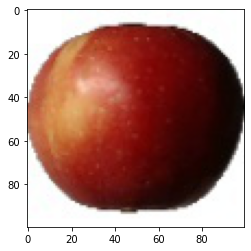

In [39]:
show_example(*dataset[2])

Label:  Pear (2)


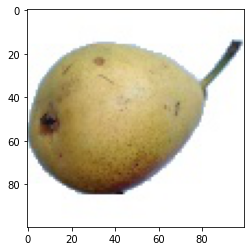

In [40]:
show_example(*dataset[1700])

Label:  Neither (1)


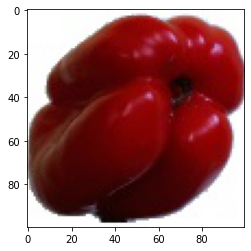

In [41]:
show_example(*dataset[1200])

In [42]:
# To ensure that we always create the same validation set, we'll also set a seed for the random number generator
random_seed = 42
torch.manual_seed(random_seed);

In [43]:
val_size = 347
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [44]:
batch_size=64 # The number of samples (data points) that would be passed through the network at a time.

In [45]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=4, shuffle=False, pin_memory=True)

In [46]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

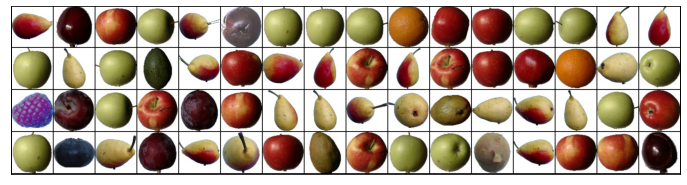

In [47]:
show_batch(train_dl)

In [48]:
torch.cuda.is_available()

True

In [49]:
# Let's define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# Next, let's define a function that can move data and model to a chosen device.

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. 
# All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [50]:
# let's check our type of device
device = get_default_device()
device

device(type='cuda')

In [51]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [52]:
input_size=3*100*100
output_size=3

In [81]:
class FruitFnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(input_size, 2048) # hidden layer
        self.linear2=nn.Linear(2048, 1024) # hidden layer
        self.linear3=nn.Linear(1024, 512)  # hidden layer
        self.linear4=nn.Linear(512, 256) #hidden layer
        self.linear5=nn.Linear(256, 64) #hidden layer
        self.linear6=nn.Linear(64, output_size) # output layer
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        # Get predictions using output layer
        return out

In [82]:
# TRAINING THE MODEL

# for epoch in range(num_epochs):
    # Training phase
    # for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
   #  for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
    
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch) # extract loss
            train_losses.append(loss)
            loss.backward() # generate gradients
            optimizer.step() # All optimizers implement a step() method, that updates the parameters.
            optimizer.zero_grad() # Clears the gradients of all optimized torch.Tensor,because every time a variable is back propogated through,
            
            # the gradient will be accumulated instead of being replaced.
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() # combine losses
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    

In [83]:
# Building Feed-Forward neural networks
Fnn_model = FruitFnnModel()
Fnn_model

FruitFnnModel(
  (linear1): Linear(in_features=30000, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=64, bias=True)
  (linear6): Linear(in_features=64, out_features=3, bias=True)
)

In [84]:
Fnn_train_dl = DeviceDataLoader(train_dl, device)
Fnn_val_dl = DeviceDataLoader(val_dl, device)
Fnn_test_dl = DeviceDataLoader(test_dl, device)
to_device(Fnn_model, device);

In [85]:
Fnn_model = to_device(FruitFnnModel(), device)

In [86]:
# EVALUATION WITHOUT TRAINING
evaluate(Fnn_model, Fnn_val_dl)

{'val_loss': 1.10209059715271, 'val_acc': 0.249284565448761}

In [87]:
num_epochs = 50 # An epoch is one single pass of all the input data through the network.

# torch.optim is a package implementing various optimization algorithms
opt_func = torch.optim.SGD

# The amount of change to the model during each step of this search process, or the step size, is called the “learning rate” .
# It is the most important hyperparameter to tune for your neural network in order to achieve good performance on your problem.
# Learning rate controls how quickly or slowly a neural network model learns a problem.
lr = 0.1

In [88]:
# We are now ready to train the model. Let's train for 6 epochs and look at the results. 
Fnn_history = fit(num_epochs, lr, Fnn_model, Fnn_train_dl, Fnn_val_dl, opt_func)

Epoch [0], train_loss: 1.0474, val_loss: 1.1487, val_acc: 0.2880
Epoch [1], train_loss: 0.9710, val_loss: 0.7785, val_acc: 0.6886
Epoch [2], train_loss: 0.7723, val_loss: 0.4878, val_acc: 0.7533
Epoch [3], train_loss: 0.6624, val_loss: 0.4525, val_acc: 0.7773
Epoch [4], train_loss: 0.6565, val_loss: 0.7396, val_acc: 0.6347
Epoch [5], train_loss: 0.7065, val_loss: 0.5435, val_acc: 0.8560
Epoch [6], train_loss: 0.7345, val_loss: 0.4753, val_acc: 0.7799
Epoch [7], train_loss: 1.0389, val_loss: 1.0453, val_acc: 0.4450
Epoch [8], train_loss: 0.6318, val_loss: 0.6316, val_acc: 0.7481
Epoch [9], train_loss: 0.5563, val_loss: 0.5943, val_acc: 0.7528
Epoch [10], train_loss: 0.5004, val_loss: 1.2218, val_acc: 0.7544
Epoch [11], train_loss: 0.6719, val_loss: 0.4202, val_acc: 0.8774
Epoch [12], train_loss: 0.5311, val_loss: 0.3739, val_acc: 0.8430
Epoch [13], train_loss: 0.4242, val_loss: 0.3715, val_acc: 0.9119
Epoch [14], train_loss: 0.4305, val_loss: 0.5893, val_acc: 0.7992
Epoch [15], train_lo

In [89]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, 'b')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. number of epochs');

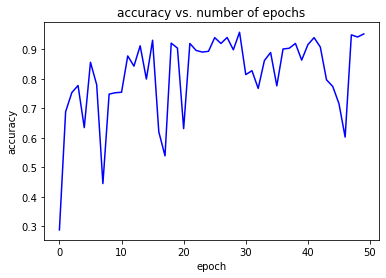

In [90]:
plot_accuracies(Fnn_history)

In [91]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, 'g')
    plt.plot(val_losses, 'b')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs : ');

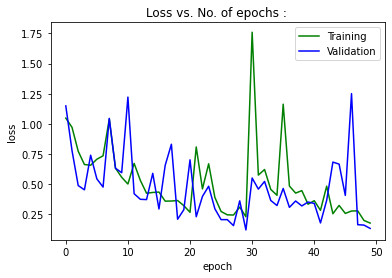

In [94]:
plot_losses(Fnn_history)

In [95]:
# EVALUATION OF THE TEST DATA
evaluate(Fnn_model, Fnn_test_dl)

{'val_loss': 0.20952004194259644, 'val_acc': 0.9401041865348816}